### Computing Influence score of a Twitter account  ###
The purpose of this experiment to use machine learning algorithms to compute social impact of any Twitter account. The social impact of a Twitter user is quantified through influence score which range between 0 to 1 with 1 being the highest impact in twitter community. The advantage of such learned model is that it can be fine tune to any specific topic, product, service or other entities.

####Description: Influencer#####


In order to weigh the impact of a social post, comment or blog, one need to find out the influence factor of a 
user in social community such as Twitter. One simple way to achieve such ranking mechanism is to associate a score that reflects his/her influence among his/her friends, peers and followers. An influential user should have the following characteristics
<ul>
    <li> Recognized and acknowledged by fellow users </li>
    <li> Can stimulate discussion, or interest or follow-up activities  </li>
    <li> Propose different perspective, novel ideas and answers </li>
    <li> Highly active in one or more forums with certain areas of expertise </li>    
</ul>

The above mentioned characteristics can translate to its equivalent numeric representation using user's meta information and the content published by the user.

### Part-1 Twitter Data Collection ###
Twitter is a social channel platform that allow users to publish short posts called "tweets". Twitter also allows developer to collect meta information about users and their tweets through a native API or third party wrapper libraries. One can extract and use such meta information associated with each twitter user and analyze the content of the user tweets to associate an influence score. 


##### Twitter API #####
In this notebook, we use tweepy (https://github.com/tweepy/tweepy) python library for Twitter API which can be installed with following commands


In [23]:
!pip install tweepy

In [24]:
!pip install vk

##### Set-up Twitter Develop account and twitter app #####
Twitter allows to create free twitter developer account and collect tweets through Twitter API. Please visit https://apps.twitter.com/ to create and register an app and collect OAUTH tokens.
<ul>
    <li> Login to your twitter account </li>
    <li> Click on "Create an application"  </li>
    <li> Fill out the form </li>
    <li> Click on manage keys and access tokens </li>
    <li> Copy access tokens and keys below </li>
</ul>

In [25]:
import tweepy
import sys, os, csv
import vk, urllib.request, csv, json, pprint, time

from pprint import pprint
from azure.storage.table import TableService, Entity, TableBatch

# need to be filled with actual keys from registered twitter app
CONSUMER_KEY = 'MdvsQgY4RpJW9e71o31waMpBY'
CONSUMER_SECRET = 'VCPtb1n8AzOYNiuhHCMdbLtnm0xAKvaT1HJoQMHJrSrYmDneO1'
OAUTH_TOKEN = '	225915389-LNCvo9cLSWjraeJ2RMsKUFm58tiVBrET0GNBM815'
OAUTH_TOKEN_SECRET = '2rCnpqMqLQu1mLYfOfPtNttmbiUGx8Q3Ixgxt41RY7zTp'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.secure = True
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
tweepyApi = tweepy.API(auth, parser=tweepy.parsers.JSONParser() \
                       , wait_on_rate_limit=True, wait_on_rate_limit_notify = True)


ImportError: No module named request

#### Data: Collect user data ####

Using above, API and OAUTH tokens, for any given twitter user, we can collect and compute the following features associated with the user.
<ul>
    <li>total followers  (followers_count)</li>
	<li>total following  (friends_count)</li>
	<li>total listings  (listed_count)</li>
	<li>total favorites : (favourites_count)</li>
	<li>total tweets by User : (statuses count)</li>
	<li>hasURL : if url is present in profile (true or false)</li>
    <li>mention_by_others : How many times user 'A' is mentioned in tweets from other authors </li>
    <li> retweet_ratio : Number of times a tweet by Author 'A' is retweeted / (Total original tweets in DB) </li>
    <li> liked_ratio :  Number of times a tweet by Author 'A' is liked by other twitter users     </li>
    <li> orig_content_ratio:  (Total tweets in DB - retweets by author 'A' ) /  Total tweets in DB </li>
    <li> hashtag_ratio:  Total tweets from Author that contain one or more HASHTAGS /  Total tweets in DB </li>
	<li> urls_ratio:  Total tweets from Author that contain one or more URLs /  Total tweets in DB </li>
	<li> symbols_ratio: Total tweets from Author that contain one or more SYMBOLS /  Total tweets in DB </li>
    <li> mentions_ratio  : Total tweets from Author that contain one or more @mentions /  Total tweets in DB</li>
	<li> reputation    = Social score that depends only on followers, following and number of tweets. We compute such social reputation as 
        log (total followers \* total followers \* status count / total following) </li>
	<li> retweet_hindex (similar to citation [h-index][hindex link]) </li>
    <li> like_hindex (similar to citation [h-index][hindex link]) </li>    	
</ul>

[hindex link]: https://en.wikipedia.org/wiki/H-index

In [27]:
# Influencer feature extractor
def hIndex(scores):
    if len(scores) == 0:
        return 0
    sortedScores = sorted(scores, reverse = True)
    i = 0
    for i, x in enumerate(sortedScores):
        if x < i+1:
            return i
    return len(scores)-1    
# compute social reputation based on followers, following, etc
def socialReputation(feature_dict):
    rep = np.log ( (1+feature_dict['followers_count']) * \
                  (1+feature_dict['followers_count']) ) + \
                np.log(1 + feature_dict['statuses_count'] ) \
                - np.log(1 + feature_dict['friends_count'])
    return rep
# compute the features described above
def compute_features(tweets, mentions):

    feature_dict = {}
    # get meta features
    user_data = tweets[0]["user"]
    feature_dict["followers_count"] = user_data["followers_count"]
    feature_dict["friends_count"] = user_data["friends_count"]
    feature_dict["listed_count"] = user_data["listed_count"]
    feature_dict["statuses_count"] = user_data["statuses_count"]
    feature_dict["has_url"] = 0 if  not user_data["url"] else 1
    
    # count out of these tweets, how many are retweets, how many are retweeted by others
    # # get tweet features
    
    # retweeted features
    retweetedOthersTweets = 0
    retweetCountList = [] # used to compute retweet_index
    #liked by others
    likedByOtherCountList = []
    
    totalReplies = 0
    tweets_with_mentions = 0
    tweets_with_hashtags = 0
    tweets_with_symbols = 0
    tweets_with_urls = 0  
    
    total_tweets = len(tweets)
    

    for tweet in tweets:       
        
        #count retweets
        if 'retweeted_status' in tweet:
            retweetedOthersTweets += 1
        elif int(tweet['retweet_count']) > 0 :
            retweetCountList.append(int(tweet['retweet_count']))
        if int(tweet['favorite_count']) > 0 :
            likedByOtherCountList.append(int(tweet['favorite_count']))
            
        if tweet["in_reply_to_status_id"] or tweet["in_reply_to_user_id"] or tweet["in_reply_to_screen_name"]:
            totalReplies += 1
        if len(tweet["entities"]["user_mentions"]):
            tweets_with_mentions += 1
        if len(tweet["entities"]["hashtags"]):
            tweets_with_hashtags += 1
        if len(tweet["entities"]["symbols"]):
            tweets_with_symbols += 1
        if len(tweet["entities"]["urls"]):
            tweets_with_urls += 1
   

    #make another API call to get @mentions
    #screen_name = user_data['screen_name']
    #search = tweepyApi.search(screen_name, count=100)
    #mentions = search["statuses"]      
    
    feature_dict["mention_by_others"] = len(mentions)    
    feature_dict["retweet_ratio"] = float(len(retweetCountList)) / total_tweets
    feature_dict["liked_ratio"] = float(len(likedByOtherCountList)) / total_tweets
    feature_dict["orig_content_ratio"] = (total_tweets - float(retweetedOthersTweets)) / total_tweets  
    feature_dict["hashtag_ratio"] = float(tweets_with_hashtags)/ total_tweets
    feature_dict["urls_ratio"] = float(tweets_with_urls)/ total_tweets
    feature_dict["symbols_ratio"] = float(tweets_with_symbols)/ total_tweets
    feature_dict["mentions_ratio"] = float(tweets_with_mentions)/ total_tweets
    
    # some derived features
    # reputation:                                     
    feature_dict["reputation"] =  socialReputation(feature_dict)
    feature_dict["retweet_hindex"] = hIndex(retweetCountList) 
    feature_dict["like_hindex"] =  hIndex(likedByOtherCountList)
  
    return feature_dict
# this routine was borrowed from StackOverflow response

def compute_vk_features(userId):
    
    table_service = TableService(account_name='seva', account_key='SgbxLwWkBH4XuGebxECoXfNVG3mVM5YjOs+SWTDUSacc+3YgUmcafYXrXdz5k0HtlZQ3AuEJ1IcFtZYeGVR9Hw==')
    friends_list =table_service.query_entities('MyVkApp', filter="(PartitionKey eq 'my_friends1') and (user_id eq '" + userId + "')")
    feature_dict = {}
                                               
    for friend in friends_list:
   
        # get meta features      
        feature_dict["followers_count"] = friend.followers_count
        feature_dict["friends_count"] = friend.friends_count
        feature_dict["listed_count"] = friend.groups_count
        feature_dict["statuses_count"] =friend.posts_count
        feature_dict["retweet_ratio"] = float(friend.posts_count - friend.own_posts_count) / friend.posts_count
        feature_dict["liked_ratio"] = float(friend.likes_count) / friend.posts_count                  
        feature_dict["orig_content_ratio"] = (friend.own_posts_count) / friend.posts_count 
                                               
        feature_dict["hashtag_ratio"] = 0
        feature_dict["urls_ratio"] = 0
        feature_dict["symbols_ratio"] = 0
        feature_dict["mentions_ratio"] = 0
        feature_dict["has_url"] = 0
        feature_dict["mention_by_others"] = 0
    
    # reputation:                                     
        feature_dict["reputation"] =  socialReputation(feature_dict)
        feature_dict["retweet_hindex"] = friend.reposts_hIndex
        feature_dict["like_hindex"] =  friend.likes_hIndex
     
    return feature_dict



def get_all_tweets(user_id):   
    #print("Downloading tweets for user {0}\n".format(user_id))
    alltweets = []  
    new_tweets = []   
    new_tweets = tweepyApi.user_timeline(user_id,count=200)
    alltweets.extend(new_tweets)
    #save the id of the oldest tweet less one
    oldest = alltweets[-1]["id"] - 1
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        #print "getting tweets before %s" % (oldest)

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = tweepyApi.user_timeline(user_id,count=200,max_id=oldest)

        #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1]["id"] - 1

        #print "...%s tweets downloaded so far" % (len(alltweets))

    #make another API call to get @mentions
    user_data = alltweets[0]["user"]
    screen_name = user_data['screen_name']
    search = tweepyApi.search(screen_name, count=100)
    mentions = search["statuses"]     
    
    return alltweets, mentions


### Part-2: Influence Score ###


#####Manual Influence Score:######

For this experiment, we handpicked approximately 1000 twitter accounts that have tweets related to SQL Server and manually assigned a score between 0 to 2000 based on their contribution. By no means, these assignments are absolute influence score but rather a ranking mechanism among accounts with certain noise. We then use these scores along with above mentioned features to convert the influencer score assignment as a linear regression model. The data set with above features along with the manual assigned score is uploaded to an Azure blob using [Azure Storage Explorer][ase link]. More information about Azure Blob storage can be found [here][blob link]

[ase link]: https://azurestorageexplorer.codeplex.com/
[blob link]: https://azure.microsoft.com/en-us/documentation/articles/storage-introduction/

In [28]:
# Azure Blob storage account and files
blob_account_name = "storagepranab" # fill in your blob account name
mycontainer = "twitter-influencer-data"       # fill in the container name
# manual score data file containing (twitter_id, twitter_screen_name, manualInfluentialScore)
twitteUsersWithScoresBlob = 'twitter-labeled-influencer-score.csv' #"twitter-labeled-influencer-score.csv"
# pre-extracted twitter feature file 
twitterFeaturesWithScoreBlob = 'twitter-influencer-fetures-with-score.csv'
#pre-trained linear regression model
LRModelTwitterInfleuncerBlob = "LRModelTwitterInfluencer.json"


###### Read twitter user ids and manual scores ######

In [29]:
# 1. Read user id from manual assigned score data
# 2. Generate features
# 3. Save the feature set to azure blob storage
import os
import pandas as pd
from azure.storage.blob import BlockBlobService
blob_service = BlockBlobService(account_name='storagepranab')

mydatafile = 'local-temp-user-data.csv'
blob_service.get_blob_to_path(mycontainer, twitteUsersWithScoresBlob, mydatafile)
manualScores = pd.read_csv(mydatafile, header=0)


##### Manual Influence Score Distribution #####
Lets take a look at the distribution of score labels

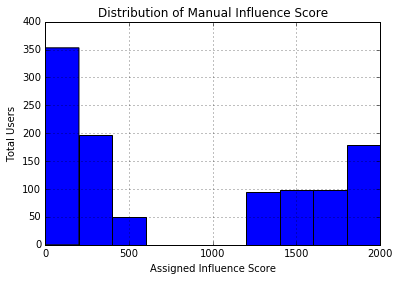

In [30]:
%matplotlib inline  
ax = manualScores['score'].hist()
ax.set_xlabel('Assigned Influence Score')
ax.set_ylabel('Total Users')
ax.set_title('Distribution of Manual Influence Score')

##### Manual Score Assignment #####
We handpicked a few user who are actively involved with a particular product (e.g.SQL server) and assigned maximum score (2000) to such users. We then selected a set of random twitter accounts (from "SQL Server" twitter search) and assigned a score between 0-600 or between 1250-2000 after comparing that user profile with the profiles that have maximum score. We ignored tweeter handles that falls in the middle range of the score to reduce any error/bias in manual assignment of influencer scores.

#### Modeling Influence Score  ####
Now we have a list of twitter users and corresponding (manually) assigned influencer score. We can learn a linear regression model to predict influencer score for other twitter users. 

##### Extract Feature for  Twitter user ######
For convinience, we have already extracted the user features and saved it as a blob in Azure Blob Storage, however one can always recompute the features using the following module to extract user features using twitter API by setting <em> extract_features_again </em> to 1. However, the following feature extraction module calls twitter API to collect user meta data and can take HOURS as twitter only allows a limited API calls within every 15 minutes.

In [31]:
# WARNING: This module calls twitter API to collect user meta data and can take several HOURS as twitter only allows 
# a limited API calls within every 15 minutes
# Set the value of extract_features_again to 1, if you absolutely need to extract features again

extract_features_again = 0

fieldnames = ['id', 'screen_name', 'statuses_count', 'followers_count', 'listed_count', 'friends_count', 'has_url', \
                  'mention_by_others', 'retweet_ratio', 'liked_ratio', 'orig_content_ratio', 'hashtag_ratio', 
                  'urls_ratio', 'symbols_ratio', 'mentions_ratio', 'reputation', 'retweet_hindex', 'like_hindex',\
                  'score']
if extract_features_again:   
    all_fet = []
    total_ids = manualScores.size
    for index, row in manualScores.iterrows():       
        print ("Processing ({0}/{1})\n".format(index, total_ids))
        print("Screen Name :" + row['screen_name'] + "(score: {0} )\n".format(row['score']))
        try:
            tweets = get_all_tweets(row['id'])                  
            features = compute_features(row['screen_name'], tweets)
            features['id'] = row['id']
            features['screen_name'] = row['screen_name']
            features['score'] = row['score']
            all_fet.append(features)
        except:
            print("Skipping twitter user : " + row['screen_name'] + "\n" )

    all_fet_df = pd.DataFrame(all_fet) 
    # write the feature files to file for later use
    all_fet_df.to_csv(fet_filename)


In [32]:
# # Read pre-computed feature files from Azure Blob Storage
mydatafile ='twitter-infleuncer-feature.csv'
blob_service.get_blob_to_path(mycontainer, twitterFeaturesWithScoreBlob, mydatafile)
features = pd.read_csv(mydatafile, header=0)


##### Learning Linear Regression Model #####

##### Feature Analysis ####
Let's take a look at the correlation of each feature with influence score. Most of our features have some correlation with influence score, which means we don't need to drop any feature except may be url_ratio. 



In [33]:
# Let see the statistics of the Features
#print ("Feature Statistics ...\n")
#print(features.describe())
# correlation with 
corr = features.corr()
print("Correlation of features with Influence score \n")
print corr['score']


Correlation of features with Influence score 

id                   -0.178973
statuses_count        0.296308
followers_count       0.078685
listed_count          0.294425
friends_count         0.247719
has_url               0.297388
mention_by_others     0.382663
retweet_ratio         0.338337
liked_ratio           0.379335
orig_content_ratio    0.252562
hashtag_ratio         0.052557
urls_ratio           -0.070514
symbols_ratio         0.047202
mentions_ratio        0.137865
reputation            0.641404
retweet_hindex        0.291408
like_hindex           0.276580
score                 1.000000
Name: score, dtype: float64


###### Train and Test Set ########
To learn and evaluate a linear regression model for influence score, we create a training and test set by splitting our data set with a 60:40 ratio training and testing


Also, most of the features have no upper bound and can have outlier values. For example, a twitter bot may have huge following but a small number of followers, so it is better to normalize the data with an upper bound on individual feature values. Let's use 95th-percentile value of each feature value to clip the feature and use min-max normalization to normalize the features to 0-1 range.

In [34]:
# randomly split the data set into to test and train set
# compute clipping value

def make_train_test_set(df, train_test_split_prct, clipping_qunatile):
    msk = np.random.rand(len(df)) < train_test_split_prct
    train_df = df[msk].copy()
    test_df = df[~msk].copy()
    # Normalize data set 
    # we can use min-max or mean-std but I am using min-max after 90th percentile clipping
    # as some of the user have very high values in particular features such follower, following etc
    thres  = train_df.quantile(clipping_qunatile)
    #print thres
    fet_list = [ x for x in list(df) if x not in ['id', 'screen_name'] ]
    for col in fet_list:
        if col :
            train_df[col] = train_df[col]/thres[col]
            test_df[col] = test_df[col]/thres[col]
        
    # clip the value to 1
    train_df.clip(0, 1)
    test_df.clip(0,1)

    # sci-kit format train and test
    cols = [col for col in list(df) if col not in ["score", 'screen_name', 'id']]

    y_train = train_df['score'].values
    y_test = test_df['score'].values
    X_train = train_df[cols].values
    X_test = test_df[cols].values

    return X_train, X_test, y_train, y_test, thres.transpose(), fet_list

#### Comparision of different Linear Regression Model ####

In [35]:
import numpy as np
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

regr_dict  = {'Bayes': linear_model.BayesianRidge(), \
                'LinearRegression': linear_model.LinearRegression(), \
                'Ridge': linear_model.RidgeCV(alphas=[0.1, 0.5, 1.0, 2.0, 5.0, 10.0]), \
                'ElasticNet': linear_model.ElasticNetCV()}
mse_list = []
# lets run the experiment multiple times
MSE = {}
Var = {}
X_train, X_test, y_train, y_test, thres, fet_list = make_train_test_set(features, 0.8 , 0.9)
# compute root mean square error for different regression models
for key in regr_dict.keys():
    regr = regr_dict[key]
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    MSE[key] =  mean_squared_error(y_test, y_pred)
    Var[key] =  regr.score(X_test, y_test)    

print ("Comparision of Models ....\n")

print("\n Model Name \t\t\t MSE \n")
for key in regr_dict.keys():
    print ("{0:20}\t\t {1:.5f}\n".format(key, MSE[key]))

Comparision of Models ....


 Model Name 			 MSE 

ElasticNet          		 0.10165

Ridge               		 0.09889

LinearRegression    		 0.09625

Bayes               		 0.09759



##### Model Selection ####
Since linear model performance is similar to other models, for simplicity lets select linear regression as our final model.

In [36]:
import json

# select feature clipping  parameters by randomly sampling the training set
# and choose average of 95th percentile as clipping value
def get_mean_clip_value():
    thres_list = []
    for run in range(1, 50):
        X_train, X_test, y_train, y_test, thres, fet_list = make_train_test_set()
        thres_list.append(thres)
        thres_df = pd.DataFrame(thres_list)
    return thres_df.mean()

# build the linear regression modle and 
def LinearRegressionModel():
    X_train, X_test, y_train, y_test, thres, fet_clip_value = make_train_test_set()
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    return regr, fet_list, fet_clip_value

# serialize the regression model and save it in json format to your azure storage container
def SerializeLinearRegressionModel(model_path):
    model, fet_list, clip_value = LinearRegressionModel()
    clip_value = get_mean_clip_value()
    # create a json object
    jsonObj = {}
    modelDict = {}
    normalizationDict = {}
    coeffDict = dict(zip(fet_list, list(model.coef_)))
    modelDict['coeff'] = coeffDict
    modelDict['intercept'] = model.intercept_
    for fet in fet_list:
        normalizationDict[fet] = clip_value[fet]
    jsonObj['LRModel'] = modelDict
    jsonObj['clippingValue'] = normalizationDict
    jsonStr = json.dumps(jsonObj, indent=4, sort_keys=True)
    with open(model_path, 'wb') as f:
        f.write(jsonStr)
        
# model is json file containing coefficients and intercept
def DeserializeLinearRegressionModel(model_path):
    with open(model_path) as f:
        model = json.loads(f.read())
        return model       

# read the pre-trained model from azure storage
model_path = 'LRModelTwitterInfluencer.json'
blob_service.get_blob_to_path(mycontainer, LRModelTwitterInfleuncerBlob, model_path)
TwitterInfluencerModel = DeserializeLinearRegressionModel(model_path)

##### Predicting Influencer Score for any Twitter user #####
For any new twitter user, we follow a similar process to predict the influence score. 
    1. Extract several tweets of the user using twitter API 
    2. Compute raw features of the twitter account using twitter API
    2. Normalize the feature
    3. Predict the influence score using our model

In [37]:
# clip and normalize the raw features
def normalize_features(fet_vec, model):
    normalize_fet = {}
    clip_dict = model["clippingValue"]
    for fet in fet_vec.keys():
        if fet in clip_dict.keys():
            normalize_fet[fet] = max(0, min(1, float(fet_vec[fet])/float(clip_dict[fet])))
    
    return normalize_fet
# model is a json object and feature_vec is a dictionary
def compute_influence_score(feature_vec, model):
    score = 0
    coeff_dict = model["LRModel"]["coeff"]
    intercept = float(model["LRModel"]["intercept"])
    for fet in feature_vec.keys():
        if fet in coeff_dict.keys():
            score = score + float(feature_vec[fet]) * float(coeff_dict[fet])
    score += intercept
    return max(min(1, score), 0)

In [38]:
# Lets compute influence score for some twitter account
def predict_influence_score(twitter_usernames, predictionModel):
    for screen_name in twitter_usernames:
        # get all tweets
        tweets, mentions = get_all_tweets(screen_name)
        # extract features
        features = compute_features(tweets, mentions)
        #print features
        # normalize features
        normalize_feature = normalize_features(features, predictionModel)
        #print normalize_feature
        # predict influence score
        influence_score = compute_influence_score(normalize_feature, predictionModel)    

        print ("\nInfluence Score of {0}: {1:.3f}\n".format(screen_name, influence_score))

In [39]:
def predict_vk_influence_score(predictionModel):
    table_service = TableService(account_name='seva', account_key='SgbxLwWkBH4XuGebxECoXfNVG3mVM5YjOs+SWTDUSacc+3YgUmcafYXrXdz5k0HtlZQ3AuEJ1IcFtZYeGVR9Hw==')
    friends_list =table_service.query_entities('MyVkApp', filter="PartitionKey eq 'my_friends1'")
    k=0
    for friend in friends_list:
        k =k+1
        try:
            print "#: ",k
            print "Id: ",friend.user_id
            print "ÐÐ¼Ñ: ",friend.first_name
            print "Ð¤Ð°Ð¼Ð¸Ð»Ð¸Ñ: ",friend.last_name
            print 'ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð´ÑÑÐ·ÐµÐ¹: ', friends_count
            print 'ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð³ÑÑÐ¿Ð¿: ', groups_count
            print 'ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð¿Ð¾ÑÑÐ¾Ð²: ', posts_count
            print 'ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ ÑÐ²Ð¾Ð¸Ñ Ð¿Ð¾ÑÑÐ¾Ð²: ', own_posts_count
            print 'ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð¿Ð¾Ð´Ð¿Ð¸ÑÑÐ¸ÐºÐ¾Ð²: ', followers_count
            print 'Ð¡Ð¾Ð¾ÑÐ½Ð¾ÑÐµÐ½Ð¸Ðµ ÑÐ²Ð¾Ð¸Ñ Ð¿Ð¾ÑÑÐ¾Ð² ÑÐ¾ Ð²ÑÐµÐ¼Ð¸ Ð¿Ð¾ÑÑÐ°Ð¼Ð¸: ', own_posts_ratio
            print 'ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð»Ð°Ð¹ÐºÐ¾Ð²: ', likes_count
            print 'hIndex likes: ',likes_hIndex
            print 'ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ ÑÐµÐ¿Ð¾ÑÑÐ¾Ð²: ', reposts_count
            print 'hIndex ÑÐµÐ¿Ð¾ÑÑÐ¾Ð²: ', reposts_hIndex
        
            # extract features
            features = compute_vk_features(friend.user_id)
            #print features
            # normalize features
            normalize_feature = normalize_features(features, predictionModel)
            #print normalize_feature
            
            # predict influence score
            influence_score = compute_influence_score(normalize_feature, predictionModel)    
        
            screen_name=friend.first_name + " " + friend.last_name
        
            print ("\nÐÐ½Ð´ÐµÐºÑ Ð²Ð»Ð¸ÑÐ½Ð¸Ñ {0}: {1:.3f}\n".format(screen_name, influence_score))
        except:
            print "ÐÑÐ¸Ð±ÐºÐ°"        

##### Compute Influence Score : Type your own list of Tweeter users here ####
Provide one or more usernames to compute their influence score

In [40]:
#twitter_user_names = ['centuno', 'azure']
#predict_influence_score(twitter_user_names, TwitterInfluencerModel)
from pprint import pprint
from azure.storage.table import TableService, Entity, TableBatch

predict_vk_influence_score(TwitterInfluencerModel)

#:  1
Id:  197147
ÐÐ¼Ñ:  Ð®Ð»Ñ
Ð¤Ð°Ð¼Ð¸Ð»Ð¸Ñ:  ÐÐ»Ð°Ð·ÐºÐ¾Ð²Ð°
ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð´ÑÑÐ·ÐµÐ¹:  ÐÑÐ¸Ð±ÐºÐ°
#:  2
Id:  5829763
ÐÐ¼Ñ:  ÐÐ¸ÐºÐ¸ÑÐ°
Ð¤Ð°Ð¼Ð¸Ð»Ð¸Ñ:  ÐÐ°Ð»Ð¾Ð»ÐµÑÐºÐ¾Ð²
ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð´ÑÑÐ·ÐµÐ¹:  ÐÑÐ¸Ð±ÐºÐ°
#:  3
Id:  396344470
ÐÐ¼Ñ:  Angela
Ð¤Ð°Ð¼Ð¸Ð»Ð¸Ñ:  Gissov
ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð´ÑÑÐ·ÐµÐ¹:  ÐÑÐ¸Ð±ÐºÐ°
#:  4
Id:  180842313
ÐÐ¼Ñ:  ÐÐ»ÐµÐºÑÐ°Ð½Ð´ÑÐ°
Ð¤Ð°Ð¼Ð¸Ð»Ð¸Ñ:  ÐÐ°ÑÐµÑÐ½Ð¸Ðº
ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð´ÑÑÐ·ÐµÐ¹:  ÐÑÐ¸Ð±ÐºÐ°
#:  5
Id:  5644164
ÐÐ¼Ñ:  ÐÐ»ÐµÐºÑÐµÐ¹
Ð¤Ð°Ð¼Ð¸Ð»Ð¸Ñ:  Ð§Ð°Ð¿Ð»ÑÐ³Ð¸Ð½
ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð´ÑÑÐ·ÐµÐ¹:  ÐÑÐ¸Ð±ÐºÐ°
#:  6
Id:  407782244
ÐÐ¼Ñ:  ÐÐ¸ÐºÐ¸ÑÐ°
Ð¤Ð°Ð¼Ð¸Ð»Ð¸Ñ:  Ð¨Ð°Ð¹ÐºÐ¸Ð½
ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð´ÑÑÐ·ÐµÐ¹:  ÐÑÐ¸Ð±ÐºÐ°
#:  7
Id:  454359782
ÐÐ¼Ñ:  ÐÐ°ÑÑÐºÐ°
Ð¤Ð°Ð¼Ð¸Ð»Ð¸Ñ:  ÐÐµÐ½Ð´ÑÐ²ÐµÐ»
ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð´ÑÑÐ·ÐµÐ¹:  ÐÑÐ¸Ð±ÐºÐ°
#:  8
Id:  197147
ÐÐ¼Ñ:  Ð®Ð»Ñ
Ð¤Ð°Ð¼Ð¸Ð»Ð¸Ñ:  ÐÐ»Ð°Ð·ÐºÐ¾Ð²Ð°
ÐÐ¾Ð»Ð¸ÑÐµÑÑÐ²Ð¾ Ð´ÑÑÐ·ÐµÐ¹:  ÐÑÐ¸Ð±ÐºÐ°
#:  9
Id:  5829763
Ð

##### Conclusion ####
In this python notebook, we demonstrated one possible approach to associate social impact score or influence score with any twitter account. The approach can be generalized to other social platform as well. This experiment can also be extended to specific product or services or other user defined entities. 